In [1]:
!pip install -r requirements.txt

/Users/jakubczyz/Desktop/PK/pk-dev/ZMUM/ZMUM-proj/venv/bin/pip: line 2: /Users/jakubczyz/Downloads/proj (2)/venv/bin/python: No such file or directory
/Users/jakubczyz/Desktop/PK/pk-dev/ZMUM/ZMUM-proj/venv/bin/pip: line 2: exec: /Users/jakubczyz/Downloads/proj (2)/venv/bin/python: cannot execute: No such file or directory


### Opis problemu

Zbiór: hotel_booking (rezerwacje hotelowe).
Liczba rekordów: ~119 tys. obserwacji
Liczba cech: 36 cech (35 cech wejściowych + 1 target)
Zmienna zależna: `is_canceled` (1 – rezerwacja anulowana, 0 – nie anulowana)
Typ problemu: **klasyfikacja binarna**

Zbiór spełnia wymaganie minimum 1000 rekordów i minimum 5–7 cech.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# https://www.kaggle.com/datasets/mojtaba142/hotel-booking

In [3]:
df = pd.read_csv('data/hotel_booking.csv')


print(df.shape)
print(df.dtypes)
print(df.head())

(119390, 36)
hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                

### Rozkład etykiet (analiza klasyfikacji)


#### Mapowanie wartości string "Undefined" na faktycznie nulle

In [4]:
cancel_counts = df['is_canceled'].value_counts()
cancel_percent = df['is_canceled'].value_counts(normalize=True) * 100

print("Liczba obserwacji w każdej klasie:")
print(cancel_counts)
print("\nProcentowe rozłożenie:")
print(cancel_percent)


Liczba obserwacji w każdej klasie:
is_canceled
0    75166
1    44224
Name: count, dtype: int64

Procentowe rozłożenie:
is_canceled
0    62.958372
1    37.041628
Name: proportion, dtype: float64


Klasa 0 (nie anulowane): ~X%, klasa 1 (anulowane): ~Y%. Dane są (w miarę) / (mocno) niezbalansowane.


In [5]:
df = df.replace(
    to_replace=r'(?i)^undefined$',
    value=np.nan,
    regex=True
)

#### Analiza brakujących wartości

Kolumny z brakującymi wartościami i ich liczba:
company                 112593
agent                    16340
meal                      1169
country                    488
distribution_channel         5
children                     4
market_segment               2
dtype: int64


/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/2909897836.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')
/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/2909897836.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{missing_percent[i]:.4f}%",


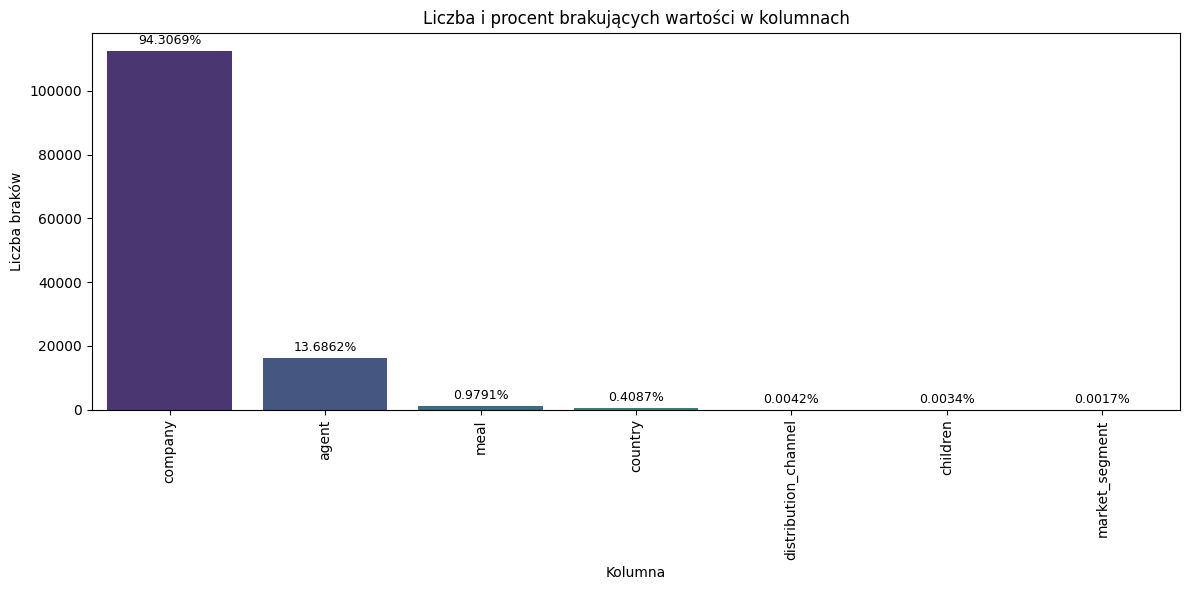

In [6]:
def show_columns_with_missing_values():
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

    print("Kolumny z brakującymi wartościami i ich liczba:")
    print(missing_counts)

    if not missing_counts.empty:
        missing_percent = (missing_counts / len(df)) * 100

        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')
        plt.xticks(rotation=90)
        plt.xlabel('Kolumna')
        plt.ylabel('Liczba braków')
        plt.title('Liczba i procent brakujących wartości w kolumnach')

        for i, v in enumerate(missing_counts.values):
            plt.text(
                i, v + (max(missing_counts.values) * 0.01),
                f"{missing_percent[i]:.4f}%",
                ha='center', va='bottom', fontsize=9, rotation=0
            )

        plt.tight_layout()
        plt.show()
    else:
        print("Nie znaleziono pustych komórek")

show_columns_with_missing_values()

#### Usuwanie nieistnotnych kolumn

In [7]:
# bardzo dużo brakujących wartości
df = df.drop(columns=['company'])

# nieistotne z punktu widzenia modelu / dane PII
df = df.drop(columns=['name', 'email', 'phone-number', 'credit_card'])
df = df.drop(columns=['arrival_date_year', 'arrival_date_day_of_month', 'arrival_date_week_number'])
df = df.drop(columns=['reservation_status', 'reservation_status_date'])

# Ekstrakcja cech

#### Zbiór a wymóg 10% braków

Zbiór już zawiera brakujące wartości (np. kolumna `company` ma ponad 90% braków), więc nie dodaję sztucznie kolejnych 10%. Pracuję na realnych brakach występujących w danych.


In [8]:
df_prepared = df.copy()

In [9]:
df_prepared['room_changed'] = (df_prepared['reserved_room_type'] != df_prepared['assigned_room_type']).astype(int)
df_prepared = df_prepared.drop(columns=['reserved_room_type', 'assigned_room_type']) 

In [10]:
# Ekstrakcja cech czasowych:
# 1. Długość pobytu (suma nocy weekendowych i tygodniowych)
df_prepared['stay_length'] = df_prepared['stays_in_week_nights'] + df_prepared['stays_in_weekend_nights']

# 2. Sezon przyjazdu (ekstrakcja z miesiąca)
def month_to_season(m):
    if m in [12, 1, 2]: return 'winter'
    if m in [3, 4, 5]: return 'spring'
    if m in [6, 7, 8]: return 'summer'
    return 'autumn'

# Najpierw zamienimy nazwy miesięcy na liczby jeśli jeszcze nie
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12,
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

if df_prepared['arrival_date_month'].dtype == 'object':
    df_prepared['arrival_date_month_num'] = df_prepared['arrival_date_month'].map(month_map)
    df_prepared['arrival_season'] = df_prepared['arrival_date_month_num'].map(month_to_season)
else:
    df_prepared['arrival_season'] = df_prepared['arrival_date_month'].map(month_to_season)


In [11]:
df_prepared['customer_engagement'] = (df_prepared['total_of_special_requests'] + df_prepared['required_car_parking_spaces']).astype(int)
df_prepared = df_prepared.drop(columns=['total_of_special_requests', 'required_car_parking_spaces']) 

# Uzupełnienie kolumn

#### Ustawienie wszystkich brakujących wartości w kolumnie 'children' na 0.0 (prosta imputacja stałą)

Braków w kolumnie `children` uzupełniono stałą 0.0 - jest to prosta metoda imputacji, ponieważ brak wartości interpretujemy jako brak dzieci w rezerwacji.

In [12]:
df_prepared['children'] = df_prepared['children'].fillna(0.0)

#### Ustawienie brakujących wartości na najczęściej występujące (imputacja modą)

Braków w cechach kategorycznych (`country`, `distribution_channel`, `market_segment`, `meal`) uzupełniono wartością najczęściej występującą (moda). Jest to druga łatwa metoda imputacji.

In [13]:
df_prepared['country'] = df_prepared['country'].fillna(df_prepared['country'].mode()[0])
df_prepared['distribution_channel'] = df_prepared['distribution_channel'].fillna(df_prepared['distribution_channel'].mode()[0])
df_prepared['market_segment'] = df_prepared['market_segment'].fillna(df_prepared['market_segment'].mode()[0])
df_prepared['meal'] = df_prepared['meal'].fillna(df_prepared['meal'].mode()[0])

#### Użycie KNN do imputacji brakujących wartości w kolumnie 'agents' (zaawansowana metoda)

Braki w kolumnie `agent` uzupełniono metodą KNNImputer (5 najbliższych sąsiadów, skalowanie MinMax), co jest bardziej zaawansowaną metodą imputacji wykorzystującą relacje między cechami numerycznymi.

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

num_complete = df_prepared.select_dtypes(include=['number']).columns.tolist()
if 'agent' in num_complete:
    num_complete.remove('agent')

predictors = [c for c in num_complete if df_prepared[c].isna().sum() == 0]
cols = ['agent'] + predictors
X = df_prepared[cols].copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed_scaled = imputer.fit_transform(X_scaled)

X_imputed = scaler.inverse_transform(X_imputed_scaled)
agent_imputed = X_imputed[:, 0]

mask_nan = df_prepared['agent'].isna().to_numpy()
df_prepared.loc[mask_nan, 'agent'] = agent_imputed[mask_nan]


Kolumny z brakującymi wartościami i ich liczba:
agent                   16340
meal                     1169
country                   488
distribution_channel        5
children                    4
market_segment              2
dtype: int64


/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/2909897836.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')
/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/2909897836.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{missing_percent[i]:.4f}%",


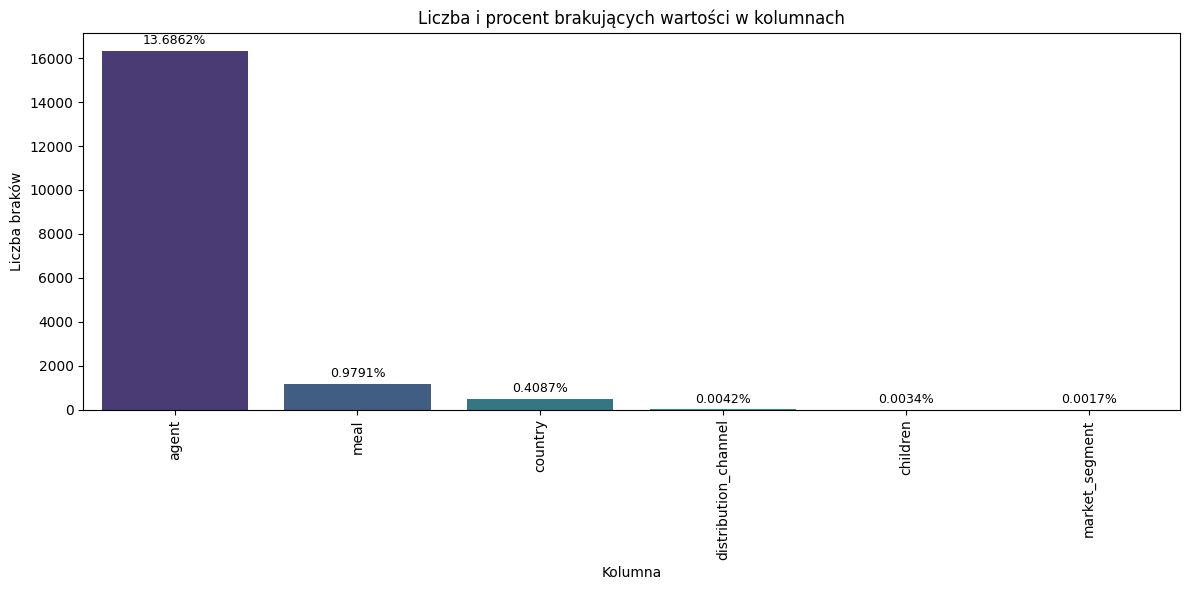

In [15]:
show_columns_with_missing_values()

## Transferowanie stringów do wartości numerycznych

#### Analiza liczby różnych wartości każdej z cech tekstowych

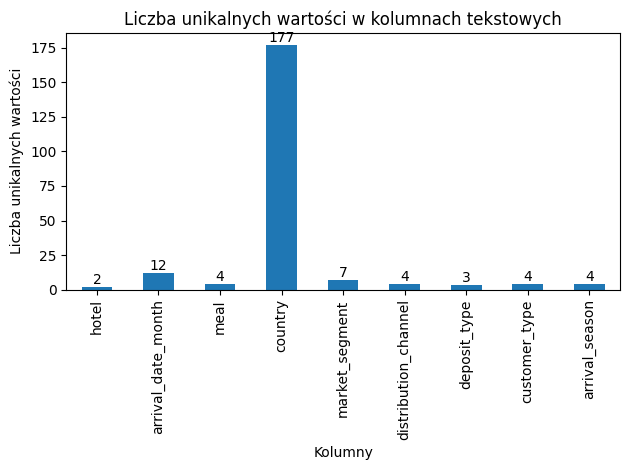

In [16]:
string_columns = df_prepared.select_dtypes(include=['object']).columns

counts = {col: df_prepared[col].nunique() for col in string_columns}
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['Liczba unikalnych wartości'])

ax = counts_df.plot(kind='bar', legend=False)
plt.ylabel('Liczba unikalnych wartości')
plt.xlabel('Kolumny')
plt.title('Liczba unikalnych wartości w kolumnach tekstowych')

for i, v in enumerate(counts_df['Liczba unikalnych wartości']):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### One-Hot Encoding

In [17]:
one_hot = [
    "hotel", 
    "meal", 
    "market_segment", 
    "deposit_type", 
    "customer_type", 
    "distribution_channel"
]

# Dodaj arrival_season jeśli istnieje
if 'arrival_season' in df_prepared.columns:
    one_hot.append("arrival_season")

df_prepared = pd.get_dummies(df_prepared, columns=one_hot, drop_first=True)

#### Ordinal Encoding dla kolumny 'arrival_date_month'

In [18]:
month_map = {
    'Jan': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df_prepared["arrival_date_month"] = df_prepared["arrival_date_month"].map(month_map)

#### Target Encoding dla kolumny 'country'

In [19]:
country_mean = df_prepared.groupby('country')['is_canceled'].mean()

df_prepared['country'] = df_prepared['country'].map(country_mean)

### Podsumowanie enkodowania

Strategia enkodowania stringów:
- **One-Hot Encoding** dla cech kategorycznych z małą liczbą kategorii (`hotel`, `meal`, `market_segment`, `deposit_type`, `customer_type`, `distribution_channel`) - tworzy osobne kolumny binarne dla każdej kategorii
- **Ordinal Encoding** dla cechy z naturalnym porządkiem (`arrival_date_month`) - miesiące mają logiczny porządek numeryczny
- **Target Encoding** dla cechy wysokokardynalnej (`country`) - zbyt dużo unikalnych wartości dla one-hot, więc używamy średniej wartości targetu w każdej kategorii

In [20]:
string_columns = df_prepared.select_dtypes(include=['object']).columns
print("Liczba kolumn z wartościami typu string:", len(string_columns))

Liczba kolumn z wartościami typu string: 0


## Mapowanie bool na wartości 0/1   

In [21]:
bool_cols = df_prepared.select_dtypes(include='bool').columns
df_prepared[bool_cols] = df_prepared[bool_cols].astype(int)

# Statystyki

/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/4267874230.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_counts.index, y=month_counts.values, palette='crest')


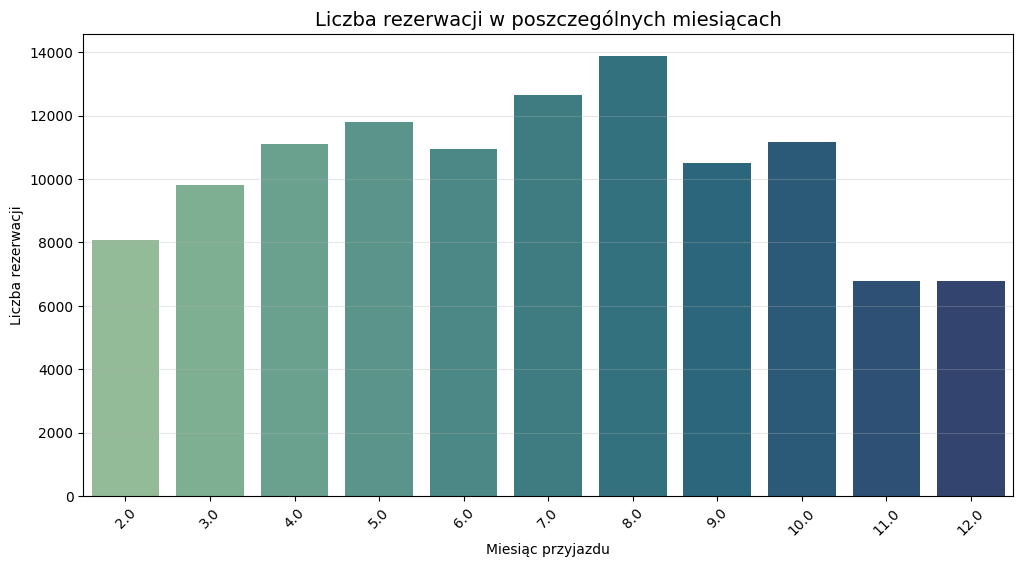

In [22]:
month_counts = df_prepared['arrival_date_month'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=month_counts.index, y=month_counts.values, palette='crest')
plt.title('Liczba rezerwacji w poszczególnych miesiącach', fontsize=14)
plt.ylabel('Liczba rezerwacji')
plt.xlabel('Miesiąc przyjazdu')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

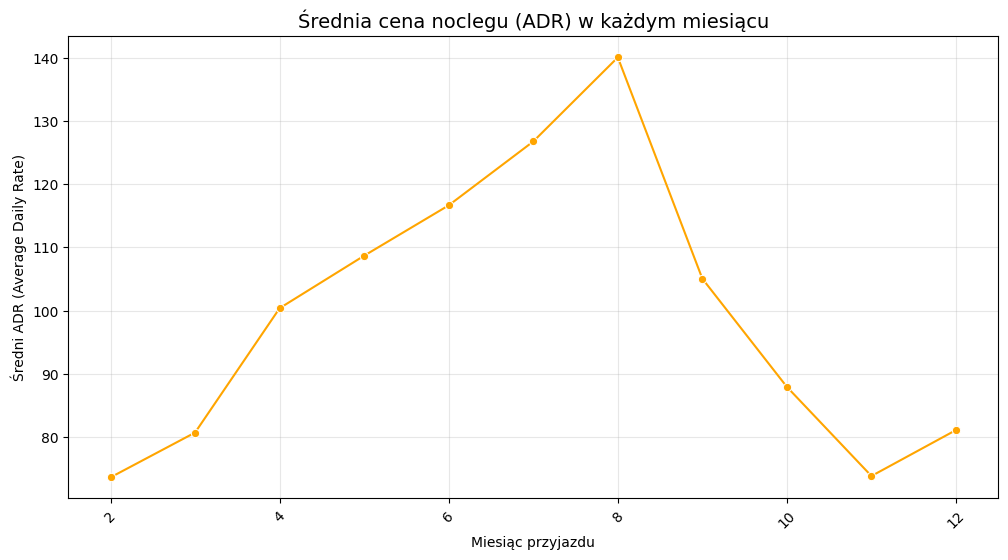

In [23]:
avg_price_month = df_prepared.groupby('arrival_date_month')['adr'].mean()

plt.figure(figsize=(12,6))
sns.lineplot(x=avg_price_month.index, y=avg_price_month.values, marker='o', color='orange')
plt.title('Średnia cena noclegu (ADR) w każdym miesiącu', fontsize=14)
plt.ylabel('Średni ADR (Average Daily Rate)')
plt.xlabel('Miesiąc przyjazdu')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/2656263301.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')


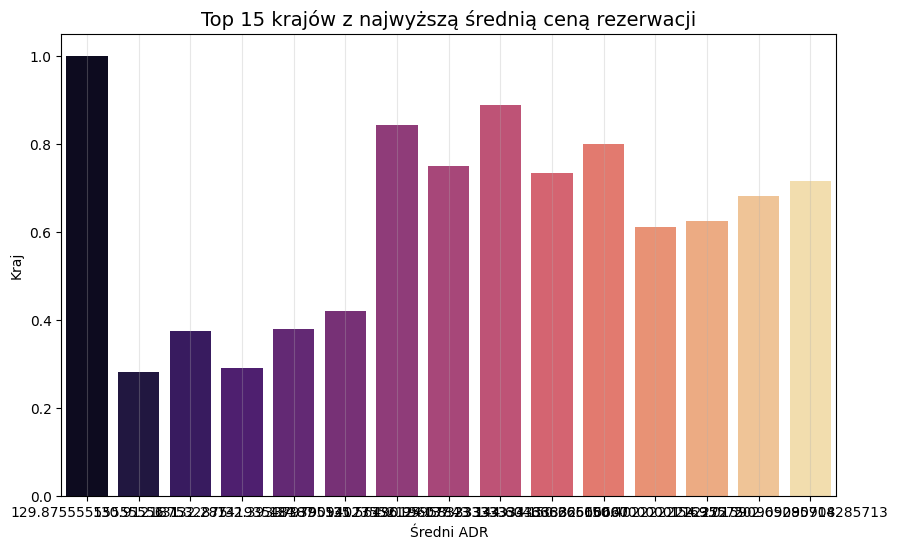

In [24]:
top_countries = df_prepared.groupby('country')['adr'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='magma')
plt.title('Top 15 krajów z najwyższą średnią ceną rezerwacji', fontsize=14)
plt.xlabel('Średni ADR')
plt.ylabel('Kraj')
plt.grid(axis='x', alpha=0.3)
plt.show()

/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/1698140366.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_children.index, y=avg_price_children.values, palette='viridis')


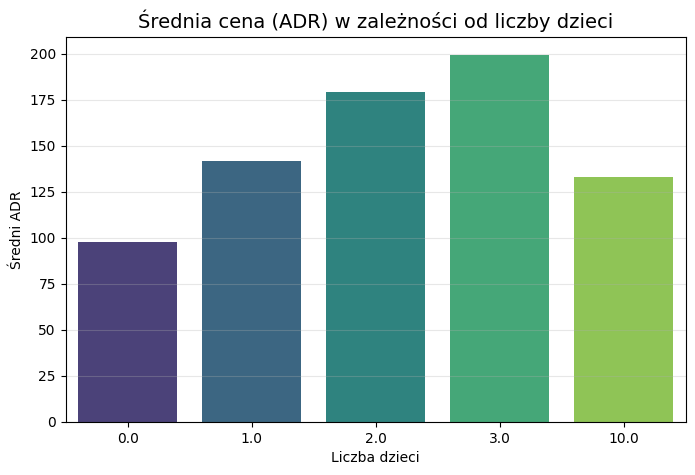

In [25]:
avg_price_children = df_prepared.groupby('children')['adr'].mean()

plt.figure(figsize=(8,5))
sns.barplot(x=avg_price_children.index, y=avg_price_children.values, palette='viridis')
plt.title('Średnia cena (ADR) w zależności od liczby dzieci', fontsize=14)
plt.xlabel('Liczba dzieci')
plt.ylabel('Średni ADR')
plt.grid(axis='y', alpha=0.3)
plt.show()

/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/1454602226.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancel_rate_month.index, y=cancel_rate_month.values, palette='Reds')


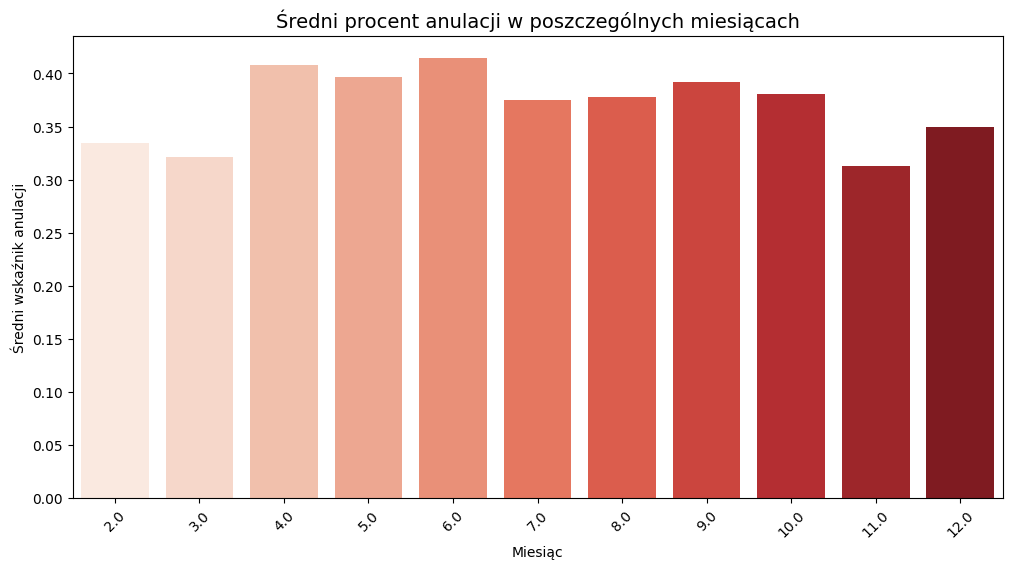

In [26]:
cancel_rate_month = df_prepared.groupby('arrival_date_month')['is_canceled'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=cancel_rate_month.index, y=cancel_rate_month.values, palette='Reds')
plt.title('Średni procent anulacji w poszczególnych miesiącach', fontsize=14)
plt.ylabel('Średni wskaźnik anulacji')
plt.xlabel('Miesiąc')
plt.xticks(rotation=45)
plt.show()


In [27]:
# plt.figure(figsize=(8,5))
# sns.barplot(x='deposit_type', y='is_canceled', data=df, estimator='mean', palette='coolwarm')
# plt.title('Odsetek anulacji w zależności od typu depozytu', fontsize=14)
# plt.ylabel('Średni wskaźnik anulacji')
# plt.xlabel('Typ depozytu')
# plt.show()

### Histogramy kluczowych cech

Poniżej przedstawiam histogramy kilku kluczowych cech numerycznych przed skalowaniem, aby zobaczyć ich rozkłady.


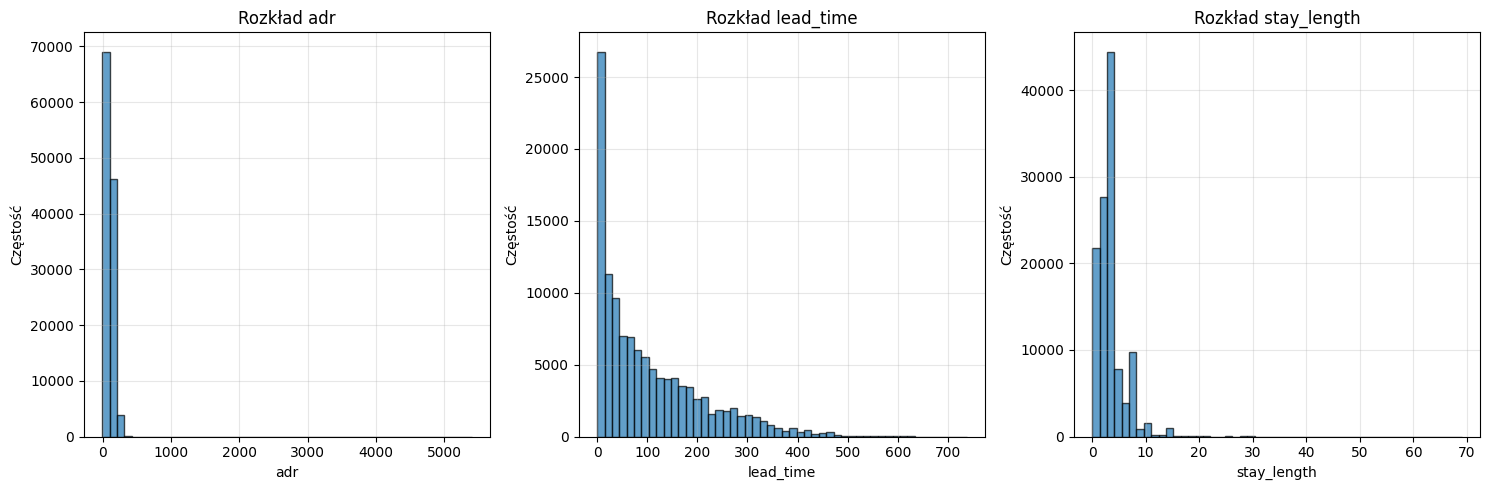

Statystyki opisowe kluczowych cech:
                 adr      lead_time    stay_length
count  119390.000000  119390.000000  119390.000000
mean      101.831122     104.011416       3.427900
std        50.535790     106.863097       2.557439
min        -6.380000       0.000000       0.000000
25%        69.290000      18.000000       2.000000
50%        94.575000      69.000000       3.000000
75%       126.000000     160.000000       4.000000
max      5400.000000     737.000000      69.000000


In [28]:
# Histogramy kluczowych cech numerycznych (przed skalowaniem)
if 'stay_length' in df_prepared.columns:
    num_cols = ['adr', 'lead_time', 'stay_length']
else:
    num_cols = ['adr', 'lead_time']

# Sprawdź czy kolumny istnieją w df_prepared
available_cols = [c for c in num_cols if c in df_prepared.columns]

if available_cols:
    fig, axes = plt.subplots(1, len(available_cols), figsize=(15, 5))
    if len(available_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(available_cols):
        axes[i].hist(df_prepared[col].dropna(), bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Rozkład {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Częstość')
        axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analiza rozkładów
print("Statystyki opisowe kluczowych cech:")
if available_cols:
    print(df_prepared[available_cols].describe())


**Analiza rozkładów:**
- `adr` (Average Daily Rate) ma rozkład prawoskośny - większość rezerwacji ma niskie ceny, z kilkoma bardzo drogimi outlierami
- `lead_time` (czas rezerwacji z wyprzedzeniem) również jest mocno skośny - większość rezerwacji jest dokonywana z małym wyprzedzeniem, ale występują też rezerwacje z bardzo dużym wyprzedzeniem
- `stay_length` (długość pobytu) pokazuje podobny wzorzec prawoskośności


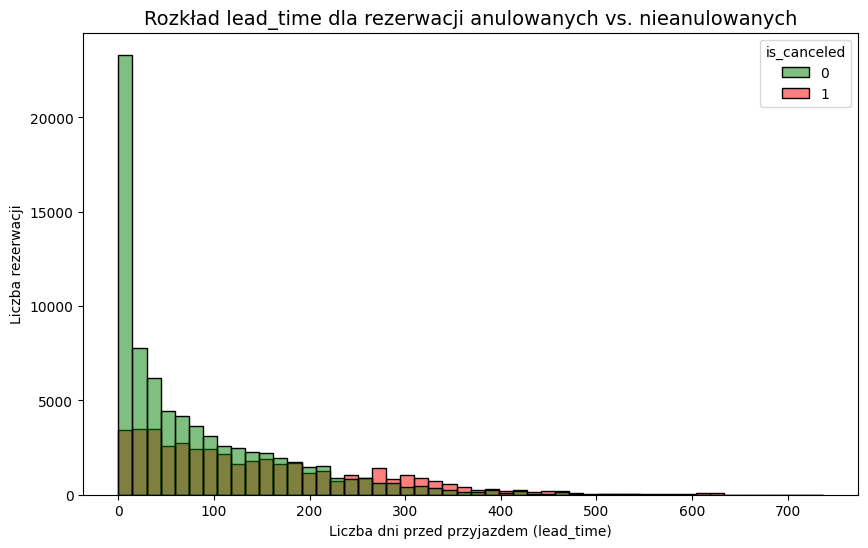

In [29]:
plt.figure(figsize=(10,6))
sns.histplot(data=df_prepared, x='lead_time', hue='is_canceled', bins=50, palette=['green', 'red'])
plt.title('Rozkład lead_time dla rezerwacji anulowanych vs. nieanulowanych', fontsize=14)
plt.xlabel('Liczba dni przed przyjazdem (lead_time)')
plt.ylabel('Liczba rezerwacji')
plt.show()

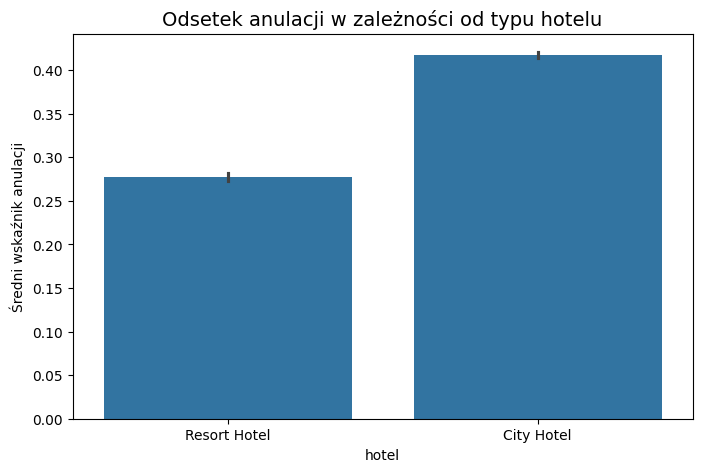

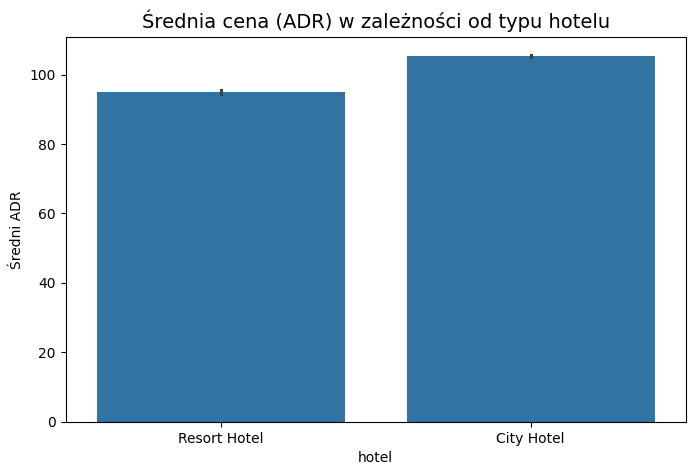

In [30]:
plt.figure(figsize=(8,5))
sns.barplot(x='hotel', y='is_canceled', data=df, estimator='mean')
plt.title('Odsetek anulacji w zależności od typu hotelu', fontsize=14)
plt.ylabel('Średni wskaźnik anulacji')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='hotel', y='adr', data=df, estimator='mean')
plt.title('Średnia cena (ADR) w zależności od typu hotelu', fontsize=14)
plt.ylabel('Średni ADR')
plt.show()

/var/folders/q1/7l1qjz4x5jz6c70cpcswn9nc0000gn/T/ipykernel_67559/2603945919.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_engagement', y='is_canceled', data=df_prepared, estimator='mean', palette='crest')


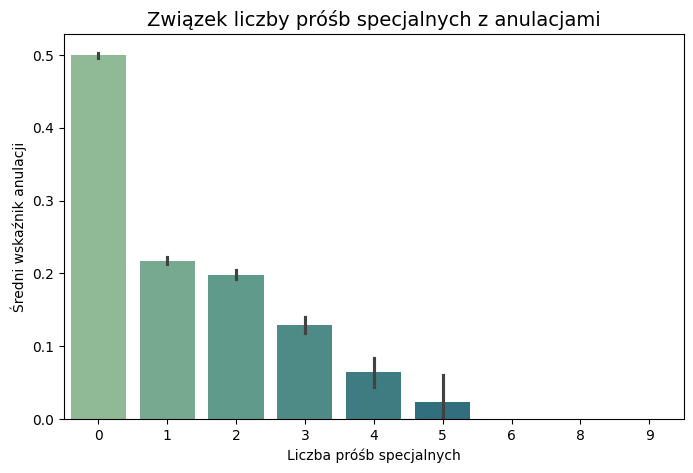

In [31]:
plt.figure(figsize=(8,5))
sns.barplot(x='customer_engagement', y='is_canceled', data=df_prepared, estimator='mean', palette='crest')
plt.title('Związek liczby próśb specjalnych z anulacjami', fontsize=14)
plt.xlabel('Liczba próśb specjalnych')
plt.ylabel('Średni wskaźnik anulacji')
plt.show()

# Pairploty

Pairplot pozwala jednocześnie spojrzeć na zależności między kilkoma zmiennymi. Poniżej przedstawiam pairplot dla kluczowych cech numerycznych oraz zmiennej targetowej `is_canceled`.

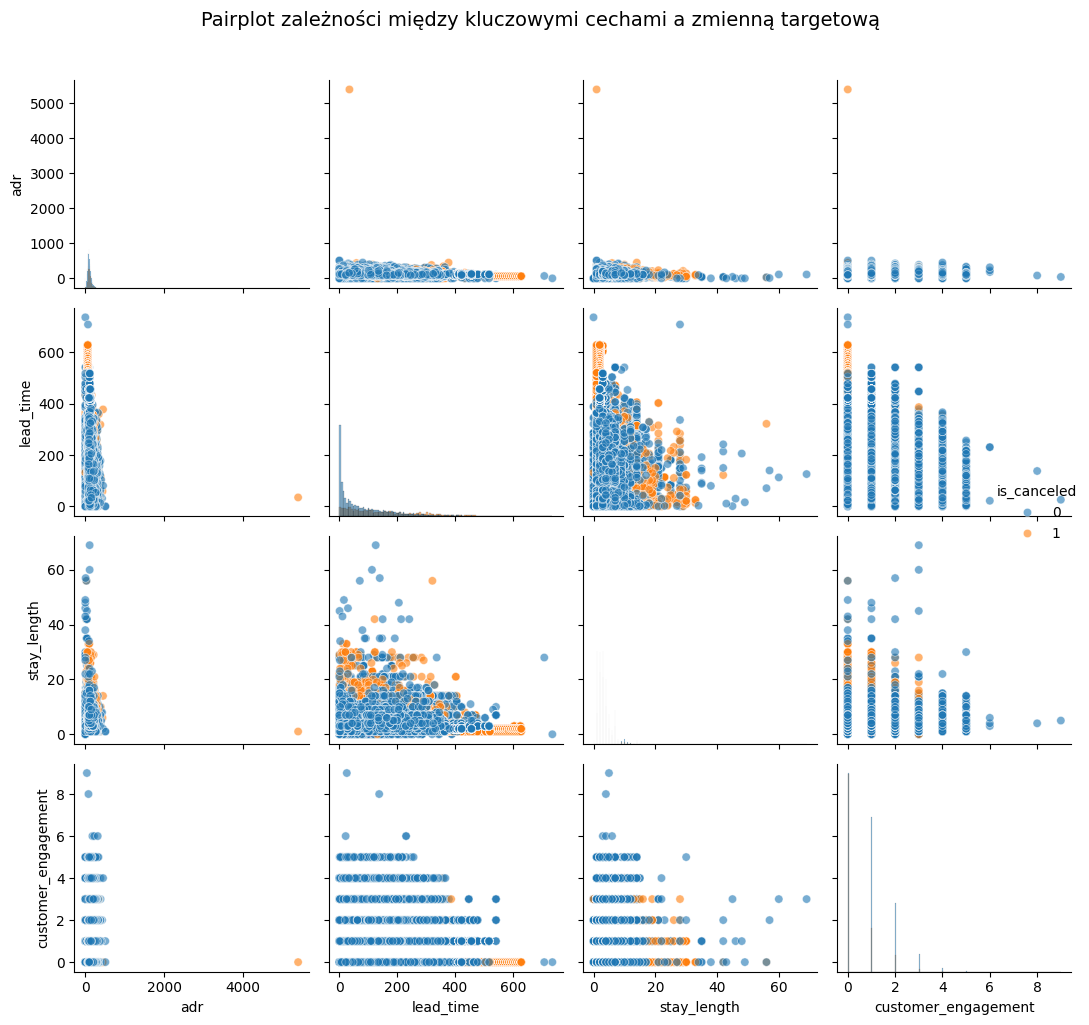

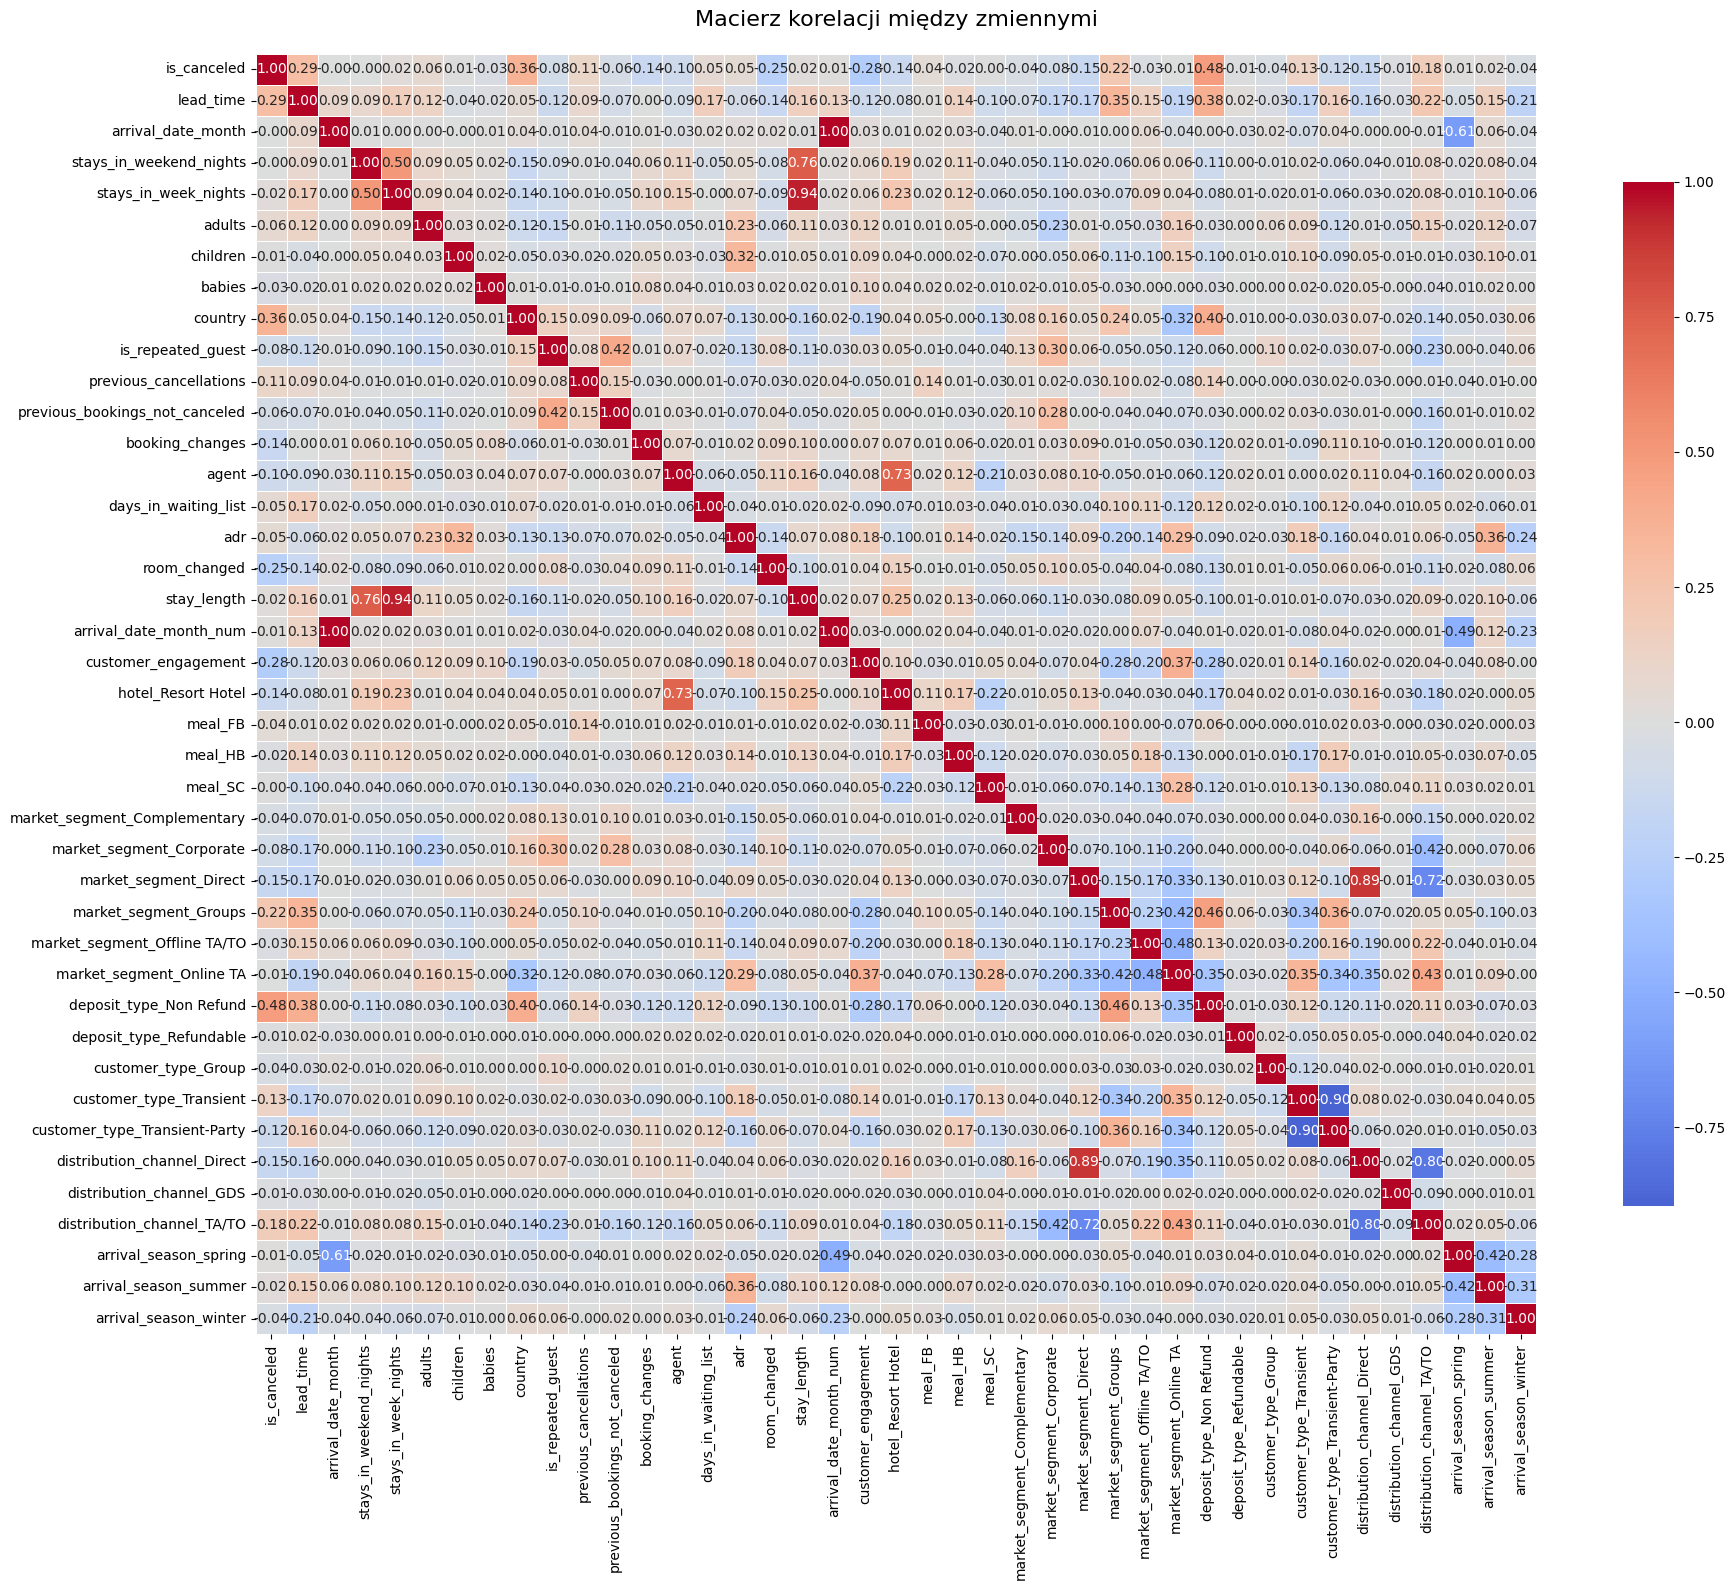


Korelacje z is_canceled (posortowane):
is_canceled                       1.000000
deposit_type_Non Refund           0.481457
country                           0.356621
lead_time                         0.293123
market_segment_Groups             0.221859
distribution_channel_TA/TO        0.176057
customer_type_Transient           0.133084
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
meal_FB                           0.038828
stays_in_week_nights              0.024765
arrival_season_summer             0.023692
stay_length                       0.017779
arrival_date_month_num            0.011022
arrival_season_spring             0.009610
children                          0.005036
meal_SC                           0.001282
stays_in_weekend_nights          -0.001791
arrival_date_month               -0.001953
market_segment_Online TA         -0.006244
deposit_type_R

In [32]:
# Pairplot dla kluczowych cech
if 'stay_length' in df_prepared.columns:
    cols_for_pairplot = ['adr', 'lead_time', 'stay_length', 'customer_engagement', 'is_canceled']
else:
    cols_for_pairplot = ['adr', 'lead_time', 'customer_engagement', 'is_canceled']

# Sprawdź czy kolumny istnieją
cols_for_pairplot = [c for c in cols_for_pairplot if c in df_prepared.columns]

sns.pairplot(
    df_prepared[cols_for_pairplot],
    hue='is_canceled',
    diag_kind='hist',
    plot_kws={'alpha': 0.6},
    height=2.5
)
plt.suptitle('Pairplot zależności między kluczowymi cechami a zmienną targetową', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# Macierz korelacji
correlation_matrix = df_prepared.corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Macierz korelacji między zmiennymi', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Wyświetlenie korelacji z is_canceled (jeśli istnieje)
if 'is_canceled' in correlation_matrix.columns:
    print("\nKorelacje z is_canceled (posortowane):")
    cancel_corr = correlation_matrix['is_canceled'].sort_values(ascending=False)
    print(cancel_corr)


# Skalowanie

In [33]:
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

In [34]:
def standardization(column):
    mean_val = column.mean()
    std_val = column.std()
    return (column - mean_val) / std_val

In [35]:
for col in df_prepared.columns:
    df_prepared[col] = min_max_scaling(df_prepared[col])

In [36]:
for col in df_prepared.columns:
    df_prepared[col] = standardization(df_prepared[col])

---

# Modelowanie i ocena modeli

Poniżej przedstawiamy pełny proces modelowania:
1. Podział zbioru na train/validation/test (ręczna implementacja)
2. Trenowanie modeli z scikit-learn i bibliotek zewnętrznych
3. Modele zespołowe (Voting i Stacking)
4. Ręczna implementacja metryk oceny
5. Porównanie wyników i wizualizacje


## Modelowanie – przygotowanie danych i podział na zbiory


### Sprawdzenie i usunięcie resztkowych braków danych

Po zastosowaniu imputacji (0.0 dla `children`, moda dla cech kategorycznych, KNNImputer dla `agent`) sprawdzamy, czy pozostały jeszcze jakieś brakujące wartości przed rozpoczęciem modelowania.


In [37]:
total_nans = df_prepared.isna().sum().sum()
print("Łączna liczba NaN w df_prepared:", total_nans)

if total_nans > 0:
    missing_per_col = df_prepared.isna().sum().sort_values(ascending=False)
    print("\nTop kolumn z brakami:")
    print(missing_per_col[missing_per_col > 0].head(20))
    
print("\nLiczba wierszy przed dropna:", len(df_prepared))

df_prepared = df_prepared.dropna().reset_index(drop=True)

print("Liczba wierszy po dropna:", len(df_prepared))
print("Łączna liczba NaN po czyszczeniu:", df_prepared.isna().sum().sum())



Łączna liczba NaN w df_prepared: 5929

Top kolumn z brakami:
arrival_date_month    5929
dtype: int64

Liczba wierszy przed dropna: 119390
Liczba wierszy po dropna: 113461
Łączna liczba NaN po czyszczeniu: 0


Po zastosowaniu imputacji (0.0 dla `children`, moda dla cech kategorycznych, KNNImputer dla `agent`) pozostała niewielka liczba braków w innych kolumnach. Ponieważ rozmiar zbioru jest duży, a liczba takich obserwacji mała, resztkowe wiersze z brakami zostały usunięte (`dropna`).


### Wydzielenie zmiennej zależnej (targetu)


In [38]:
import numpy as np
import pandas as pd

# Wydzielenie zmiennej zależnej (targetu)
# Kolumna 'is_canceled' jest obecnie zeskalowana, ale ma tylko 2 unikalne wartości.
# Mapujemy je jawnie na 0/1, żeby metryki binarne były czytelne.

unique_labels = np.sort(df_prepared['is_canceled'].unique())
assert len(unique_labels) == 2, "Target nie jest binarny!"

label_mapping = {
    unique_labels[0]: 0,  # klasa "negatywna" (np. nieanulowane)
    unique_labels[1]: 1   # klasa "pozytywna" (np. anulowane)
}

y = df_prepared['is_canceled'].map(label_mapping)
X = df_prepared.drop(columns=['is_canceled'])

print("Kształt X:", X.shape)
print("Rozkład klas w y:")
print(y.value_counts(normalize=True) * 100)


Kształt X: (113461, 40)
Rozkład klas w y:
is_canceled
0    62.615348
1    37.384652
Name: proportion, dtype: float64


In [39]:
def stratified_train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Ręczny, stratyfikowany podział na zbiory train/val/test:
    - zachowujemy podobny rozkład klas w każdym zbiorze
    - nie używamy train_test_split z scikitlearna
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-8, "Udziały muszą sumować się do 1.0"

    rng = np.random.default_rng(random_state)
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    indices = np.arange(len(y))
    train_idx, val_idx, test_idx = [], [], []

    for cls in np.unique(y):
        cls_mask = (y == cls).to_numpy()
        cls_indices = indices[cls_mask]

        rng.shuffle(cls_indices)

        n_total = len(cls_indices)
        n_train = int(n_total * train_size)
        n_val = int(n_total * val_size)
        # reszta idzie do testu
        n_test = n_total - n_train - n_val

        train_idx.extend(cls_indices[:n_train])
        val_idx.extend(cls_indices[n_train:n_train + n_val])
        test_idx.extend(cls_indices[n_train + n_val:])

    # dla bezpieczeństwa tasujemy jeszcze indeksy w obrębie zbiorów
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    rng.shuffle(test_idx)

    X_train = X.iloc[train_idx].reset_index(drop=True)
    y_train = y.iloc[train_idx].reset_index(drop=True)

    X_val = X.iloc[val_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)

    X_test = X.iloc[test_idx].reset_index(drop=True)
    y_test = y.iloc[test_idx].reset_index(drop=True)

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = stratified_train_val_test_split(
    X, y,
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    random_state=42
)

print("Rozmiary zbiorów:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("\nRozkład klas:")
print("Train:\n", y_train.value_counts(normalize=True) * 100)
print("Val:\n", y_val.value_counts(normalize=True) * 100)
print("Test:\n", y_test.value_counts(normalize=True) * 100)

# Kontrola: sprawdzenie czy nie ma NaN-ów w zbiorach
print("\nNaN-y w zbiorach:")
print("NaN-y w X_train:", X_train.isna().sum().sum())
print("NaN-y w X_val:", X_val.isna().sum().sum())
print("NaN-y w X_test:", X_test.isna().sum().sum())


Rozmiary zbiorów:
Train: (79421, 40) Val: (17018, 40) Test: (17022, 40)

Rozkład klas:
Train:
 is_canceled
0    62.615681
1    37.384319
Name: proportion, dtype: float64
Val:
 is_canceled
0    62.616054
1    37.383946
Name: proportion, dtype: float64
Test:
 is_canceled
0    62.613089
1    37.386911
Name: proportion, dtype: float64

NaN-y w zbiorach:
NaN-y w X_train: 0
NaN-y w X_val: 0
NaN-y w X_test: 0


## Ręczna implementacja metryk jakości (accuracy, precision, recall, F1)


In [40]:
def confusion_matrix_manual(y_true, y_pred):
    """
    Ręczne liczenie macierzy pomyłek dla problemu binarnego (0/1).
    Zwraca macierz:
        [[TN, FP],
         [FN, TP]]
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    tn = np.sum((y_true == 0) & (y_pred == 0)) # True Negative
    fp = np.sum((y_true == 0) & (y_pred == 1)) # False Positive
    fn = np.sum((y_true == 1) & (y_pred == 0)) # False Negative
    tp = np.sum((y_true == 1) & (y_pred == 1)) # True Positive

    return np.array([[tn, fp],
                     [fn, tp]])


def accuracy_manual(cm):
    tn, fp, fn, tp = cm.ravel()
    return (tp + tn) / (tp + tn + fp + fn)


def precision_manual(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0


def recall_manual(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0


def f1_manual(cm):
    p = precision_manual(cm)
    r = recall_manual(cm)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0


## Modele z scikit-learn


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Proste modele bez tuningu hiperparametrów - używamy domyślnych wartości
sklearn_models = {
    "log_reg": LogisticRegression(random_state=42, n_jobs=-1),
    "random_forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "knn": KNeighborsClassifier(),
    "gradient_boosting": GradientBoostingClassifier(random_state=42),
}


## Modele z bibliotek zewnętrznych (XGBoost, LightGBM)


In [42]:

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Proste modele bez tuningu hiperparametrów - używamy domyślnych wartości
external_models = {
    "xgb": XGBClassifier(random_state=42, n_jobs=-1),
    "lgbm": LGBMClassifier(random_state=42, n_jobs=-1)
}


## Modele zespołowe (Voting + Stacking)


In [43]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# VotingClassifier (soft voting – uśrednianie prawdopodobieństw)
# Proste modele bez tuningu - używamy modeli zdefiniowanych wcześniej
voting_clf = VotingClassifier(
    estimators=[
        ("log_reg", sklearn_models["log_reg"]),
        ("rf", sklearn_models["random_forest"]),
        ("gb", sklearn_models["gradient_boosting"]),
    ],
    voting="soft",  # zakładamy, że wszystkie modele mają predict_proba
    n_jobs=-1
)

# StackingClassifier – meta-model (logistic regression) nad kilkoma bazowymi
# Proste modele bez tuningu - używamy domyślnych wartości
stacking_clf = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(random_state=42, n_jobs=-1)),
        ("gb", GradientBoostingClassifier(random_state=42)),
        ("knn", KNeighborsClassifier()),
    ],
    final_estimator=LogisticRegression(random_state=42, n_jobs=-1),
    n_jobs=-1
)

ensemble_models = {
    "voting_soft": voting_clf,
    "stacking": stacking_clf
}


## Trening modeli, liczenie metryk ręcznie i porównanie wyników


In [44]:
all_models = {}
all_models.update(sklearn_models)
all_models.update(external_models)
all_models.update(ensemble_models)

results = []
conf_matrices = {}

for name, model in all_models.items():
    print(f"\n=== Trening modelu: {name} ===")
    model.fit(X_train, y_train)

    # Predykcja na zbiorze testowym
    y_pred_test = model.predict(X_test)

    # Ręczna macierz pomyłek + metryki
    cm = confusion_matrix_manual(y_test, y_pred_test)
    acc = accuracy_manual(cm)
    prec = precision_manual(cm)
    rec = recall_manual(cm)
    f1 = f1_manual(cm)

    results.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

    conf_matrices[name] = cm

# Tabela z porównaniem wyników
results_df = pd.DataFrame(results).set_index("model").sort_values(by="f1", ascending=False)
results_df



=== Trening modelu: log_reg ===

=== Trening modelu: random_forest ===

=== Trening modelu: knn ===

=== Trening modelu: gradient_boosting ===

=== Trening modelu: xgb ===

=== Trening modelu: lgbm ===
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29691, number of negative: 49730
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 79421, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373843 -> initscore=-0.515764
[LightGBM] [Info] Start training from score -0.515764

=== Trening modelu: voting_soft ===

=== Trening modelu: stacking ===


,accuracy,precision,recall,f1
model,,,,
stacking,0.889966,0.877458,0.820239,0.847884
random_forest,0.889143,0.882846,0.811125,0.845467
xgb,0.876806,0.858030,0.803426,0.829830
voting_soft,0.874280,0.880678,0.767756,0.820349
lgbm,0.870109,0.853929,0.787241,0.819230
gradient_boosting,0.851016,0.829886,0.756600,0.791550
knn,0.840971,0.808608,0.752828,0.779722
log_reg,0.819351,0.824679,0.656348,0.730948


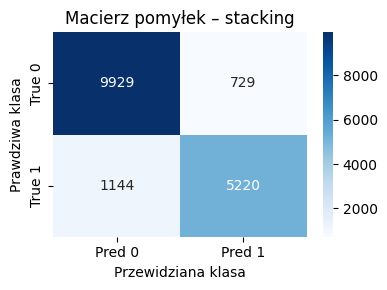

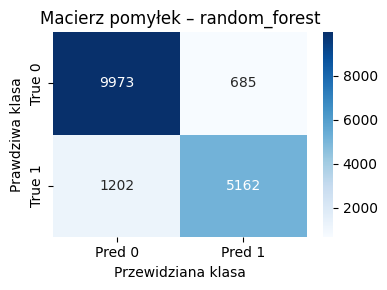

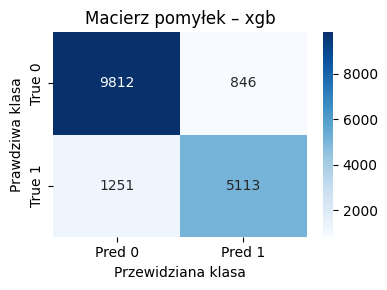

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

top_models = results_df.head(3).index.tolist()

for name in top_models:
    cm = conf_matrices[name]
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Pred 0', 'Pred 1'],
        yticklabels=['True 0', 'True 1']
    )
    plt.title(f"Macierz pomyłek – {name}")
    plt.xlabel("Przewidziana klasa")
    plt.ylabel("Prawdziwa klasa")
    plt.tight_layout()
    plt.show()


    # Uzycie prostych modeli, i brak tuningu na jakis learning rate max depth itp.
